In [68]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import savemat, loadmat
from scipy.signal import decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

sys.path += ['..']
from readers.base import NeuralynxReader, OpenEphysReader, buffer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
%%time
p = '/media/sil2/Data/Lizard/Stellagama/SA07/SA07_22_05_21_Trial08_18D/Record Node 117'
rd = OpenEphysReader(p, channel=17, lowpass=150, decimate_q=None, wavelet=None, window=1.5, overlap=0.5,
                     use_multiprocessing=False, use_slow_cycles=False, is_flat_cwt=False)
rd.fs

CPU times: user 1.1 s, sys: 2.79 s, total: 3.89 s
Wall time: 3.9 s


20000.0

In [64]:
v, t = rd.read(i_start=0, i_stop=int(2.5*3600*rd.fs))
len(v)

180000000

In [65]:
m = loadmat((Path(p) / 'regev_cache' / 'signal_annotations.mat').as_posix(), squeeze_me=True)
signal_annotations = {label: roi/1000 for label, roi in zip(m['labels'], m['labelsDict'])}

In [5]:
for label, limits in signal_annotations.items():
    d = limits[:,1] - limits[:,0]
    print(f'{label}: {d.min():.1f}-{d.max():.1f}sec ({d.mean():.1f}sec)')

ShW: 1.3-3.5sec (2.4sec)
ShW_broken: 1.8-4.2sec (3.0sec)
spindles: 0.4-26.9sec (4.2sec)
saw: 1.3-41.5sec (9.3sec)
small_ShW: 0.6-2.1sec (1.1sec)


In [87]:
def plot_annotations(label, cols=10, n_plots=None):
    n_plots = n_plots or signal_annotations[label].shape[0]
    rows = int(np.ceil(n_plots / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
    axes = axes.flatten()
    for i, j in enumerate(range(n_plots)):
        i_start = np.argmin(np.abs(t - signal_annotations[label][j, 0]))
        i_stop = np.argmin(np.abs(t - signal_annotations[label][j, 1]))
        axes[i].plot(t[i_start:i_stop], v[i_start:i_stop])
        axes[i].set_title(j)
    fig.tight_layout()

# plot_annotations('ShW')

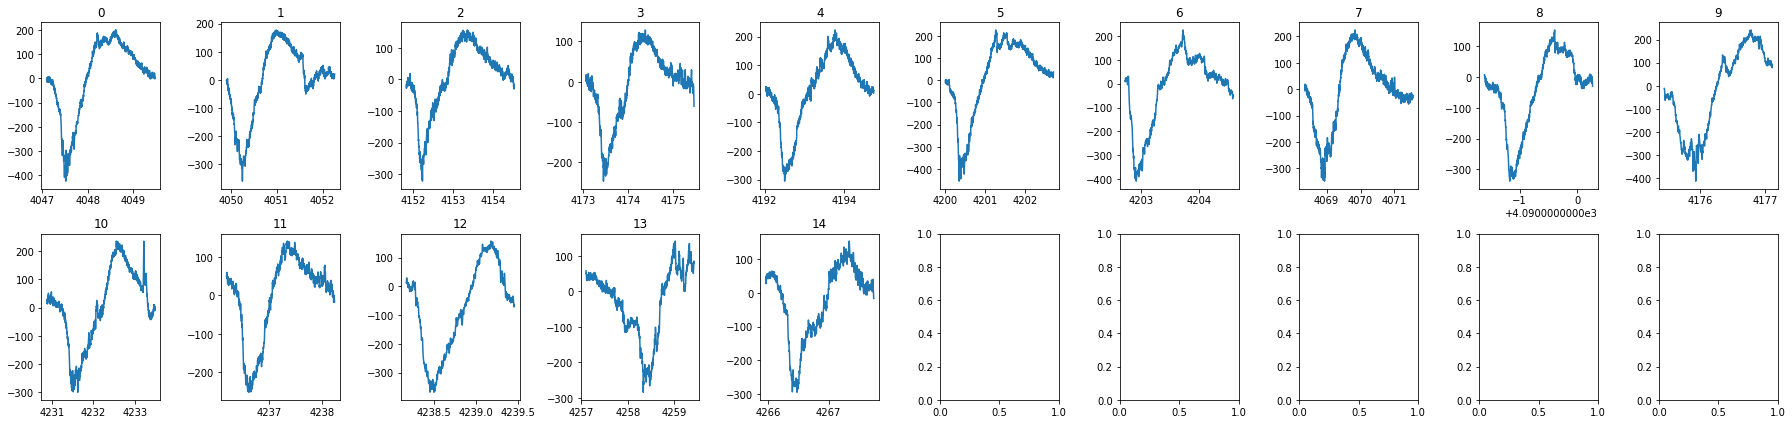

In [67]:
plot_annotations('ShW', n_plots=15)

  0%|          | 0/5 [00:00<?, ?it/s]

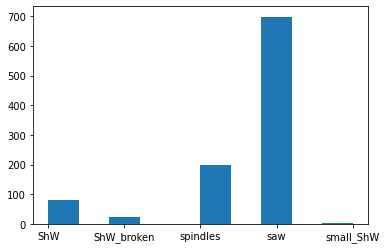

In [97]:
def build_annotation_set(seg_duration=2, decimate_q=None):
    seg_length = int(rd.fs * seg_duration)
    if seg_length % 2:
        seg_length -= 1
    X, y = [], []
    for label, limits in tqdm(signal_annotations.items()):
        for t_start, t_stop in limits:
            i_start = np.argmin(np.abs(t - t_start))
            i_stop = np.argmin(np.abs(t - t_stop))
            if label in ['ShW', 'ShW_broken']:
                center_id = np.argmin(v[i_start:i_stop]) + i_start
                S = [v[int(center_id-(seg_length/2)):int(center_id+(seg_length/2))]]
            else:
                v_ = v[i_start:i_stop]
                if len(v_) < seg_length:
                    continue
                S, _ = buffer(v_, w=seg_length, noverlap=0, is_debug=False)
            for seg in S:
                if len(seg) != seg_length:
                    continue
                if decimate_q:
                    seg = decimate(seg, decimate_q)
                X.append(seg)
                y.append(label)
    plt.hist(y)
    return np.vstack(X), np.vstack(y)


x_train, labels = build_annotation_set(1.3, decimate_q=15)

In [99]:
x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)

In [101]:
from tslearn.clustering import KShape, KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# np.random.shuffle(X_train)
# For this method to operate properly, prior scaling is required
sz = x_train.shape[1]
gak_km = KernelKMeans(n_clusters=3,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=0)
y_pred = gak_km.fit_predict(x_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

     |████████████████████████████████| 136 kB 778 kB/s eta 0:00:01


In [98]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.datasets import CachedDatasets
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Our pipeline consists of two phases. First, data will be normalized using
# min-max normalization. Afterwards, it is fed to a KNN classifier. For the
# KNN classifier, we tune the n_neighbors and weights hyper-parameters.
n_splits = 3
pipeline = GridSearchCV(
    Pipeline([
            ('normalize', TimeSeriesScalerMinMax()),
            ('knn', KNeighborsTimeSeriesClassifier())
    ]),
    {'knn__n_neighbors': [5, 25], 'knn__weights': ['uniform', 'distance']},
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
)
pipeline.fit(x_train, labels)
results = pipeline.cv_results_

/home/regev/anaconda3/envs/lfp_clustering/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/regev/anaconda3/envs/lfp_clustering/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KeyboardInterrupt: 

In [ ]:
print('Got the following accuracies on the test set for each fold:')
header_str = '|'
columns = ['n_neighbors', 'weights']
columns += ['score_fold_{}'.format(i + 1) for i in range(n_splits)]
for col in columns:
    header_str += '{:^12}|'.format(col)
print(header_str)
print('-'*(len(columns) * 13))
for i in range(len(results['params'])):
    s = '|'
    s += '{:>12}|'.format(results['params'][i]['knn__n_neighbors'])
    s += '{:>12}|'.format(results['params'][i]['knn__weights'])
    for k in range(n_splits):
        score = results['split{}_test_score'.format(k)][i]
        score = np.around(score, 5)
        s += '{:>12}|'.format(score)
    print(s.strip())

best_comb = np.argmax(results['mean_test_score'])
best_params = results['params'][best_comb]
print('\nBest parameter combination:')
print('weights={}, n_neighbors={}'.format(best_params['knn__weights'],
                                          best_params['knn__n_neighbors']))

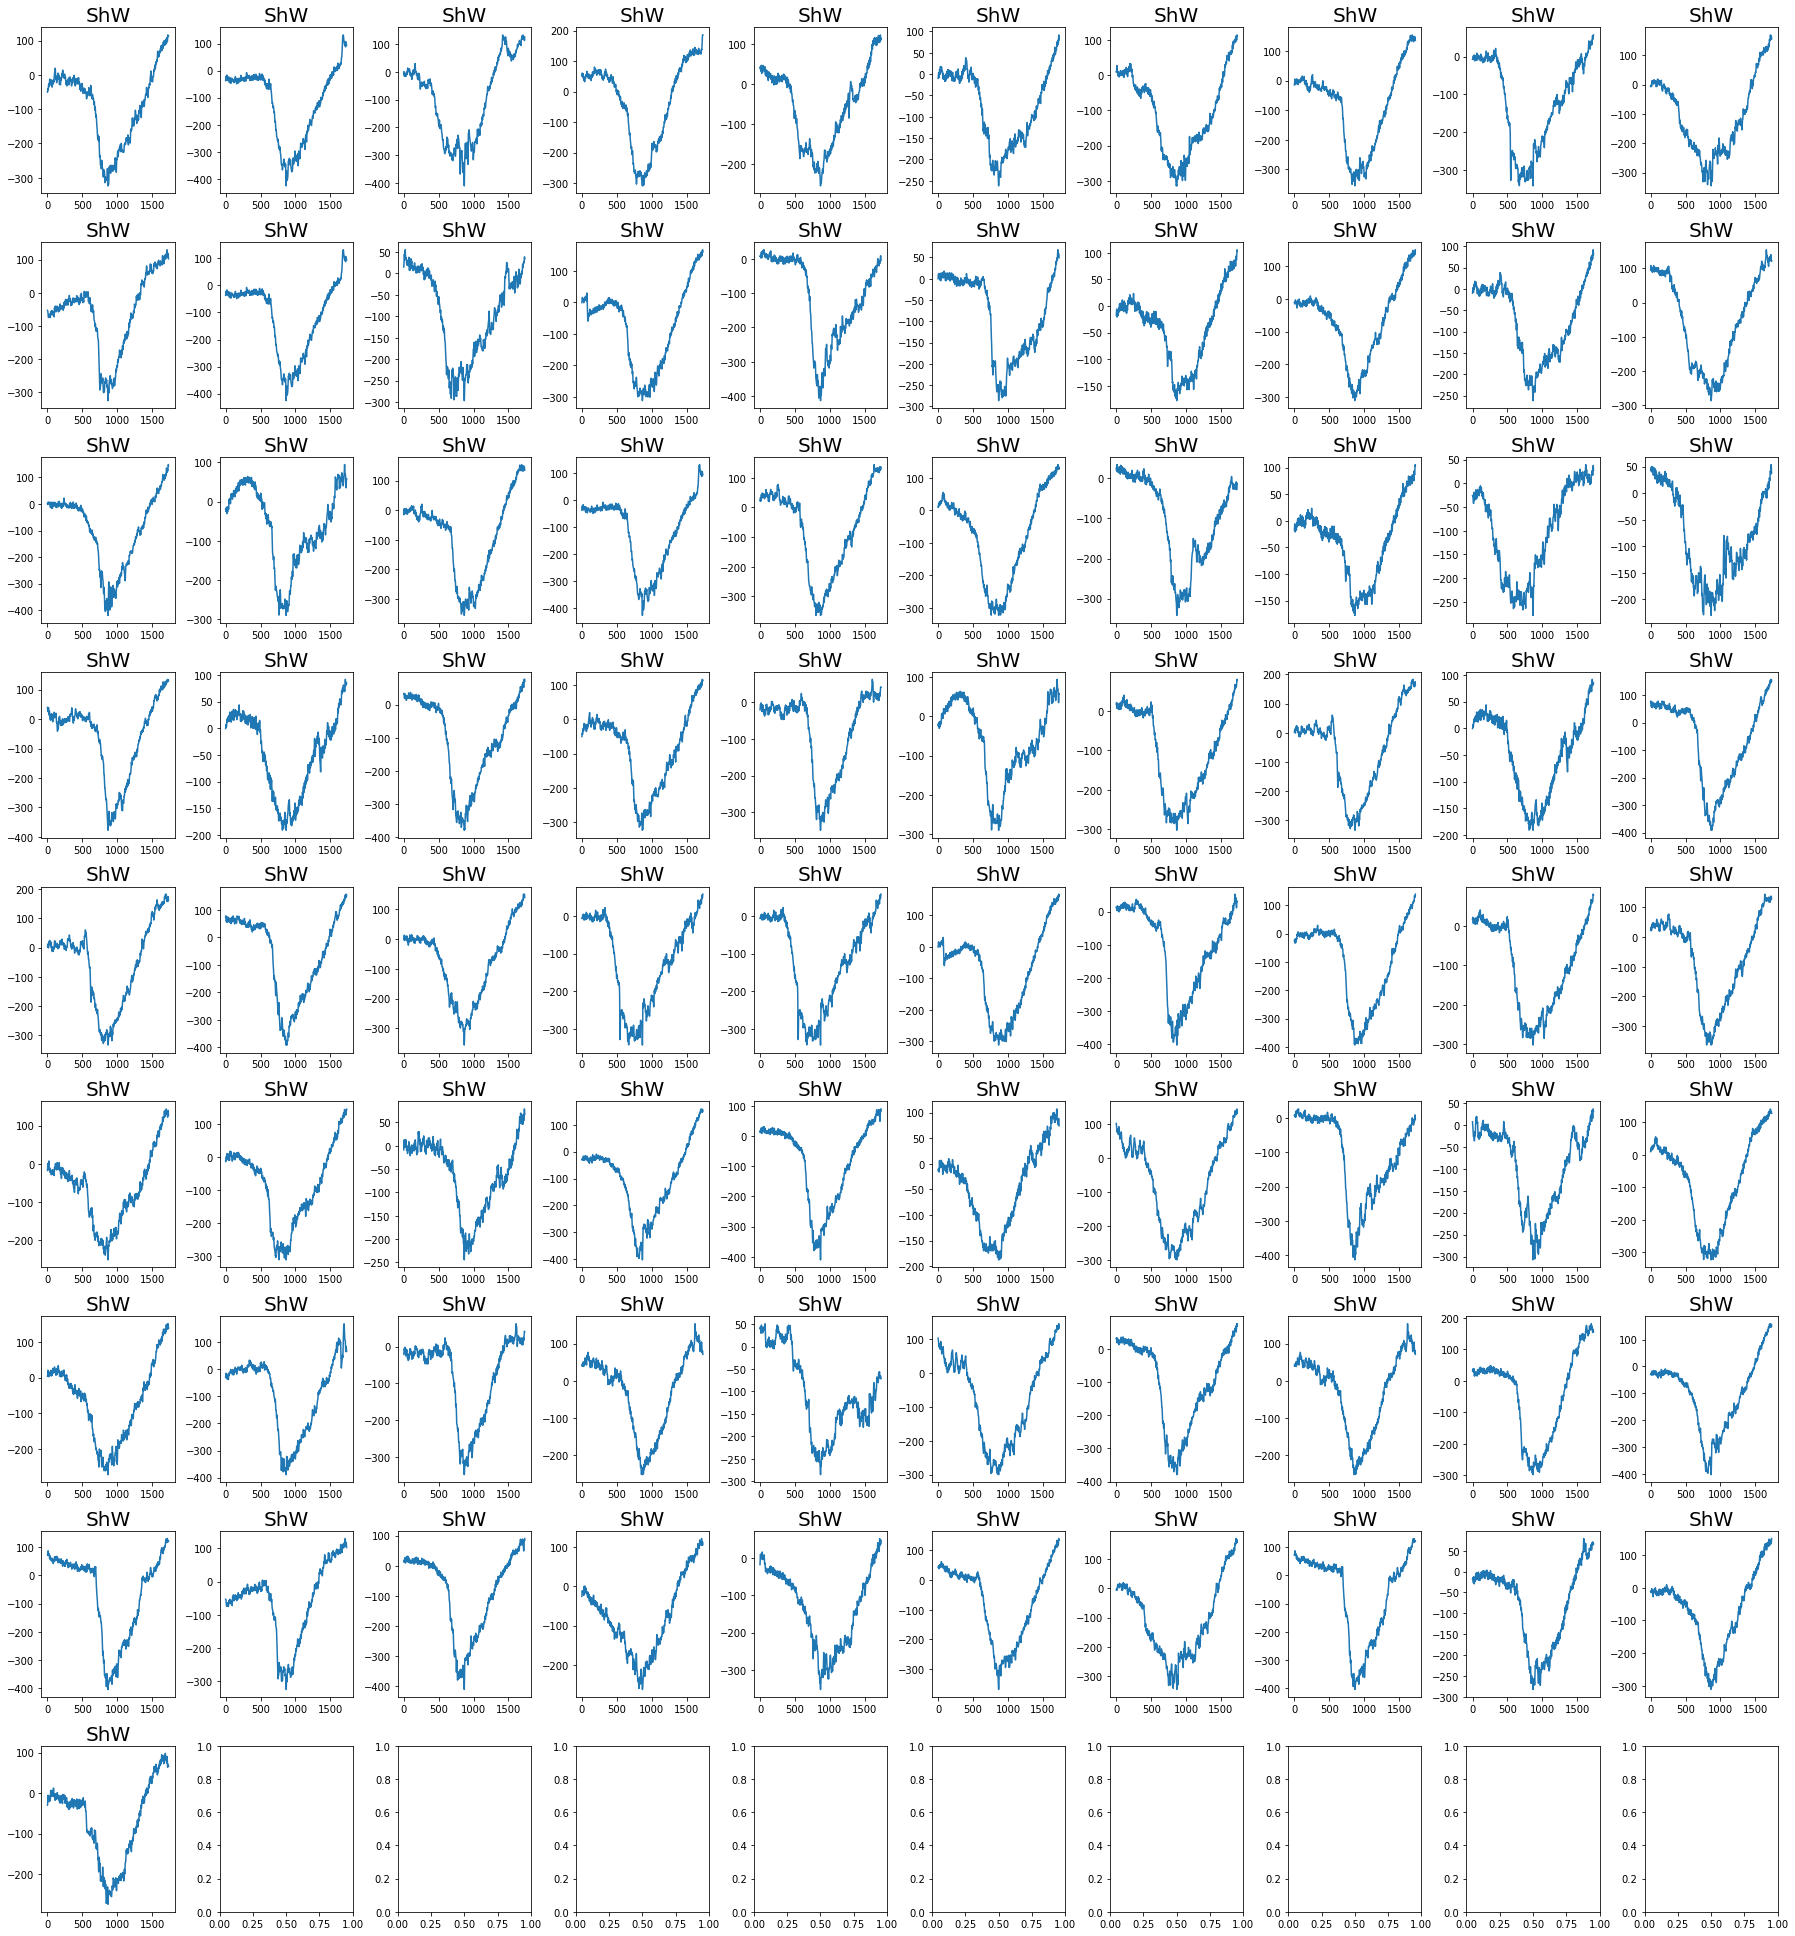

In [92]:
def plot_train_set(X, y, n_group=None, cols=10, groups2plot=None):
    sig2plot = []
    groups2plot = groups2plot or np.unique(y)
    for g in groups2plot:
        idx = np.where(y==g)[0]
        n = n_group or len(idx)
        sig2plot.extend(idx[np.random.randint(0, len(idx), n)].tolist())
    rows = int(np.ceil(len(sig2plot) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
    axes = axes.flatten()
    for i, j in enumerate(sig2plot):
        axes[i].plot(X[j, :])
        axes[i].set_title(y[j, 0], fontsize=20)
    fig.tight_layout()

plot_train_set(x_train, labels, groups2plot=['ShW'])

In [93]:
if len(x_train.shape) == 2:
    x_train = x_train.reshape((*x_train.shape, 1))
scaler = TimeSeriesScalerMeanVariance()
x_train = scaler.fit_transform(x_train)
x_train, x_test = train_test_split(x_train, test_size=0.1)
print(f'Train set shape: {x_train.shape}')
print(f'Test set shape: {x_test.shape}')

Train set shape: (1632, 1734, 1)
Test set shape: (182, 1734, 1)


In [94]:
savemat('/media/sil2/Data/regev/stellagama/annotation_set.mat', {'x_train': x_train, 'x_test': x_test, 'labels': labels})

In [95]:
np.unique(labels)

array(['ShW', 'ShW_broken', 'saw', 'small_ShW', 'spindles'], dtype='<U10')